# 6 . 학습 관련 기술들

### 수업 환경 구성을 위한 코드 (수업전 실행)

#### MNIST 데이터 적재
* common 모듈 사용을 위한 경로 지정시 pickle 오류 발생 문제 회피
* 사전에 load_mnist 라이브러리 import 및 MNIST 파일 데이터 load

In [ ]:
# 6.0.1 mnist.py 업로드
from google.colab import files
src = list(files.upload().values())[0]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# 6.0.2 MNIST 데이터 적재
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

#### common 라이브러리
* 수업 시간에 작성한 여러 함수 및 원활한 프로그램 수행을 위한 utility 등 저자 제공 파일들
* common 라이브러리 내 모듈 사용을 위해 google drive mount 및 경로 지정
* 사전에 G 드라이브 내 Colab Notebooks 디렉토리에 common 폴더 복제

In [ ]:
# 6.0.3 common 폴더 마운트
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 6.0.4 수행 경로 변경
%cd /content/drive/MyDrive/Colab Notebooks

## 6.1 매개변수 갱신


### 6.1.1 모험가 이야기

### 6.1.2 확률적 경사하강법 (SGD)

$$ \mathbf{W} \gets \mathbf{W} + \eta \frac {\partial L}{\partial \mathbf{W}}$$

In [ ]:
# 6.1.2.1 확률적 경사하강법 동작 원리
class SGD :
    def __init__(self, lr = 0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [ ]:

# 6.1.2.2 SGD 클래스 적용 예시  psuedo code
"""
network = TwoLayerNet
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_minio_batch()
    grads = network.gradient (x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)

""""""

### 6.1.3 SGD의 단점


### 6.1.4 모멘텀

$$ \mathbf{ v} \gets   \alpha \mathbf{ v}- \eta \frac {\partial L} {\partial \mathbf{W}}$$
$$ \mathbf{W} \gets \mathbf{W} + \mathbf{v}$$

In [ ]:
# 6.1.4.1 모멘텀 동작 원리
class Momentum :
    def __init__(self, lr= 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update (self, params, grads):
        if self.v is None :
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] -\
                                self.lr * grads[key]
            params[key] += self.v[key]


### 6.1.5 AdaGrad

$$ \mathbf{h} \gets \mathbf{h}  + \frac {\partial L} {\partial \mathbf{W}} \odot \frac {\partial L} {\partial \mathbf{W}}$$
$$ \mathbf{W} \gets \mathbf{W} + \eta \frac{1}{ \sqrt { \mathbf{h}}} \frac {\partial L}{\partial \mathbf{W}} $$

In [ ]:
# 6.1.5.1 AdaGrad 동작 원리
class AdaGrad :
    def __init__(self, lr = 0.01) :
        self.lr = lr
        self.h = None

    def update(self, params, grads ):
        if self.h == None :
            self.h = {}
            for key, val in params.items() :
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] += self.lr *grads[key] / \
                      (np.sqrt(self.h[key]) + 1e-7 )

### 6.1.6 Adam


### 6.1.7 어느 갱신 방법을 이용할 것인가

#### optimizer 별 최소점 접근 경로

* 초기값 (-7, 3) 에서 시작하여 각 optimizer의 방법으로 30번 매개변수를 갱신하여 최소점을 찾는 경로 시각화
$$ f(x,y) =\frac {1} {20} x^2 + y^2$$
$$ \frac {\partial f} {\partial x} = \frac {x}{10}$$
$$\frac {\partial f} {\partial y} = 2y $$

In [ ]:
# 6.1.7.1 Optimizer별 최소점 접근 경로 시각화
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
# 사전 정의된 옵티마이저
from common.optimizer import *

# 대상이 되는 함수 정의
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

# 초기값 설정
init_pos = (-7.0, 2.0)

# 매개변수와 기울기 초기값
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

# 옵티마이저 생성
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)


# 4개의 그래프 작성을 위한 figure
plt.figure(figsize=(10,10))

# 옵티마이저별 탐색
for idx, key in enumerate(optimizers, 1 ) :
    optimizer = optimizers[key] # 옵티마이저 지정
    x_history = []
    y_history = []    # 이동 경로
    params['x'], params['y'] = init_pos[0], init_pos[1]  # 초기값 설정

    # optimizer 별로 30 번의 매개변수 갱신을 시도함.
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y']) # 미분값은 구해줌
        optimizer.update(params, grads)  ### 매개 변수 갱신 ###


    # 갱신 결과 plotting
    # 데이터 생성
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # for simple contour line
    mask = Z > 7
    Z[mask] = 0

    # plot
    plt.subplot(2, 2, idx ) # subplot을 생성하여 그래프 작성

    plt.plot(x_history, y_history, 'o-', color="red") # 매개변수 출력
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

### 6.1.8 MNIST 데이터 셋으로 본 갱신 방법 비교

#### optimizer 별 손실 비교 on MNIST

In [ ]:
# 6.1.8.1 MNIST 분류 손실 비교
# 은닉층 4개층 100개 노드
# 은닉층 활성화 함수 : ReLU
# 가중치 초기 설정 : He

# 배치 사이즈 : 118
# 최대 반복 회수 :  2000 iteration

# 실험 최적화 optimizer 4종  : SGD, Momentum, AdaGrad, Adam

import matplotlib.pyplot as plt

#from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

# 0:MNIST 데이터 읽어들이기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1:실험 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}

# optimize 별 신경망 구성
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []


# 2: 학습 ==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # optimize 별 학습 수행
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print( f"=========== iteration: {i} ===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(f"{key} : {loss}")


In [ ]:
# 6.1.8.2  갱신 방법 별 손실율 그래프
#  3.그래프 작성 =========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)

plt.figure (figsize = (6,5))

for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key],
             markevery=100, label=key)
plt.title ('MNIST Loss by optimizer')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.xlim(0,2000)
plt.legend()
plt.show()


## 6.2 가중치의 초기값


### 6.2.1 초기값을 0으로 하면

### 6.2.2 은닉층의 활성화값 분포 (sigmoid)

#### 기울기 소실  :   $ N (0, 1)$

In [ ]:
# 6.2.2.1  은닉층 활성화값 분포 시각화
#  5개 은닉층, 각 층 노드 수 100개
#  활성화 함수 : 시그모이드 함수
#  입력데이터 개수 : 1000 개
#  가중치의 초기값 : 표준 정규 분포 N(0,1)

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000,100) #1000 개의 입력 데이터

node_num = 100          # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5   # 은닉층이 5개
activations={}          # 활성화 값 저장소

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations [i-1]   # 이전 출력값이 입력값

    w = np.random.randn(node_num, node_num)*1   #가중치 초기값 : 표준정규분포

    z = np.dot(x, w)    # 신호 총합
    a = sigmoid(z)      # 활성화
    activations[i] = a  # 활성화 값 저장

In [ ]:
# 6.2.2.2 각 층의 활성화 값 분포 히스토그램 작성

fig = plt.figure(figsize=(15,3))
fig.suptitle('stddev = 1 Normal Distribution  on Sigmoid',
             fontsize = 15 , y = 1.05)

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str (i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

* 시그모이드 함수는 0과 1 부근에서 미분이 0에 가까워진다.  기울기가 0에 가까워지면 학습이 이어지지 않느다.
* 활성화 값이 양 끝으로 어진다는 것은 신호 총합의 절대값이 크다는 의미
* 가중치 값을 줄여주어야 한다.

#### 표현력의 제약 :  $ N (0, 0.01), \sigma = 0.01$

In [ ]:
# 6.2.2.3 위 # 6.2.2.1 과 동일한 조건에서 가중치 초기값을 표준편차 0.01인 정규분포로 변경하여 진행

x = np.random.randn(1000,100) #1000 개의 입력 데이터

node_num = 100          # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5   # 은닉층이 5개
activations={}          # 활성화 값 저장소

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations [i-1]   # 이전 출력값이 입력값

    w = np.random.randn(node_num, node_num)* 0.01   ### 가중치 초기값 변경 : 표준편차 0.01 ###

    z = np.dot(x, w)    # 신호 총합
    a = sigmoid(z)      # 활성화
    activations[i] = a  # 활성화 값 저장

# 5개 층의 분포 시각화 @ stddev = 0.01  on Sigmoid
fig = plt.figure(figsize=(15,3))
fig.suptitle('stddev = 0.01 Normal Distribution  on Sigmoid',
             fontsize = 15 , y = 1.05)

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str (i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

* 표준편차를 0.01인 정규 분포에 따르는 가중치 초기값은, 매우 0에 근접한 값 -0.03~0.03
* 그 결과 시그모이드 활성화 값은 0.5 부근에 집중되어 있다.
* 기울기 소실 문제는 해결 되지만, 유사한 가중치 값을 가지면 뉴런을 많이 만든 것이 의미 없게 된다.
* **표현력을  제한**하는 문제가 발생한다.

#### Xavier 초기값 : $N (0, \sigma), \sigma = \sqrt{1\over n}$

In [ ]:
# 6.2.2.4 위 # 6.2.2.1 과 동일한 조건에서 가중치 초기값을 Xavier 초기값으로 변경하여 진행

x = np.random.randn(1000,100) #1000 개의 입력 데이터

node_num = 100          # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5   # 은닉층이 5개
activations={}          # 활성화 값 저장소

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations [i-1]   # 이전 출력값이 입력값

    ### 가중치 초기값 변경 : Xavier ###
    w = np.random.randn(node_num, node_num)/np.sqrt (node_num)

    z = np.dot(x, w)    # 신호 총합
    a = sigmoid(z)      # 활성화
    activations[i] = a  # 활성화 값 저장

# 5개 층의 분포 시각화 @ Xavier on Sigmoid
fig = plt.figure(figsize=(15,3))
fig.suptitle('Xavier on Sigmoid', fontsize = 15 , y = 1.05)

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str (i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

* Xavier 초기값  표준편차가 앞 계층 노드의  1/√𝑛인 정규 분포에 따르는 가중치.
* 1층에서 적절히 넓게 분포 되고, 이후 층이 깊어져도 일정 이상의 분포를 유지한다.

### 6.2.3 ReLU를 사용할 때의 가중치 초기값

#### $ N (0, \sigma), \sigma = 0.01$ on ReLU

In [ ]:
# 6.2.3.1 활성화 함수가 ReLU인 경우로 진행한다.  stddev 0.01 의 정규분포

def relu(x):
    return np.maximum (0, x)

x = np.random.randn(1000,100) #1000 개의 입력 데이터

node_num = 100          # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5   # 은닉층이 5개
activations={}          # 활성화 값 저장소

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations [i-1]   # 이전 출력값이 입력값

    ### 가중치 초기값 변경 : stddev = 0.01 정규분포 ###
    w = np.random.randn(node_num, node_num) * 0.01

    z = np.dot(x, w)
    a= relu(z)      ### a = sigmoid(z)를 치환 ###
    activations[i] = a


# 5개 층의 분포 시각화 @ stddev = 0.01 정규분포 on ReLU
fig = plt.figure(figsize=(15,3))
fig.suptitle('stddev = 0.01 Normal Distribution on ReLU', fontsize = 15 , y = 1.05)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str (i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim(0, 7000)

plt.show()

* 𝑁(0, 0.01) 은 값이 0 으로 쏠린다. 학습이 이루어지지 않게 된다. 기울기 소실

#### Xavier on ReLU : $N (0, \sigma), \sigma = \sqrt{1\over n}$

In [ ]:
# 6.2.3.2 Xavier on ReLU

x = np.random.randn(1000,100) #1000 개의 입력 데이터

node_num = 100          # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5   # 은닉층이 5개
activations={}          # 활성화 값 저장소

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations [i-1]   # 이전 출력값이 입력값

    ### 가중치 초기값 변경 : Xavier ###
    w = np.random.randn(node_num, node_num) /np.sqrt (node_num)

    z = np.dot(x, w)
    a= relu(z)      ### a = sigmoid(z)를 치환 ###
    activations[i] = a

# 5개 층의 분포 시각화 @ Xavier  on ReLU
fig = plt.figure(figsize=(15,3))
fig.suptitle('Xavier on ReLU', fontsize = 15, y = 1.05)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str (i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim(0,7000)
plt.show()

* Xavier 초기값에서도 층이 깊어지면서 치우침이 커지고 기울기 소실 문제가 발생한다.



#### He on ReLU : $N (0, \sigma), \sigma = \sqrt{2\over n}$

In [ ]:
# 6.2.3.3 He 초기값 on ReLU

x = np.random.randn(1000,100) #1000 개의 입력 데이터

node_num = 100          # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5   # 은닉층이 5개
activations={}          # 활성화 값 저장소

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations [i-1]   # 이전 출력값이 입력값

    ### 가중치 초기값 변경 : He ###
    w = np.random.randn(node_num, node_num)* np.sqrt (2/node_num)   ## test He

    z = np.dot(x, w)
    a= relu(z)     ### a = sigmoid(z)를 치환 ###
    activations[i] = a

# 5개 층의 분포 시각화 @ He on ReLU
fig = plt.figure(figsize=(15,3))
fig.suptitle('He on ReLU', fontsize = 15, y = 1.05)

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str (i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim(0,7000)


plt.show()

* He 초기값에서는 모든 층에서 균일하게 분포 되었다.
* ReLU 함수는 음수에서 0이 되므로,  나머지를 넓게 사용 하기 위해 Xavier 입력값의 2배격인 He 입력값을 채택


### 6.2.4 MNIST 데이터셋으로 본 가중치 초기값 비교

##### 가중치 초기값별 손실비교 on MNIST
* weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
* optimizer = SGD(lr=0.01)

In [ ]:
# 6.2.4.1 MNIST 데이터셋을 서로 다른 가중치 초기값으로 학습 결과 비교
# 은닉층 4개층 100개 노드
# 은닉층 활성화 함수 : ReLU

# 배치 사이즈 : 128
# 최대 반복 회수 : 2000 iteration
# 훈련방식 : SGD   학습률 0.01

# 실험 초기값 3종  : std= 0.01,  Xavier, He

import numpy as np
import matplotlib.pyplot as plt

from mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

# 0:MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:실험의 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
#weight_init_types = {'std=0.01': 0.01, 'Xavier': 0.1, 'He': 0.14} # 은닉층 기준
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
# 3개의 신경망을 생성
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784,
                                  hidden_size_list=[100, 100, 100, 100],
                                  output_size=10,
                                  weight_init_std=weight_type)
    train_loss[key] = []


# 2:학습==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print(f"=========== iteration:{i} ===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(f'{key} : {loss}')




In [ ]:
# 6.2.4.4 Xavier, He 초기값
# 입력층
xavier_mnist = np.sqrt(1/784)
he_mnist = np.sqrt (2/ 784)
# 은닉층
xavier_hidden = np.sqrt(1/100)
he_hidden = np.sqrt (2/ 100)
xavier_mnist, he_mnist, xavier_hidden, he_hidden

In [ ]:
# 6.2.4.3 가중치 초기값에 따른 손실감소 그래프
# 3.그래프 ==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)

fig = plt.figure(figsize=(6,5))


for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]),
             marker=markers[key],
             markevery=100,
             label=key)

plt.title ('MNIST Loss by initial value ')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.xlim(0,2000)
plt.ylim(0, 2.5)
plt.legend()
plt.show()

* std= 0.01의 경우는 거의 학습이 이루어지지 않으나, Xavier, He에서는 순조롭게 학습이 이루어진다. He가 약간 학습속도가 빠르다.

## 6.3 뱃치 정규화


### 6.3.1 뱃치 정규화 알고리즘

$$ \mu_B \gets \frac {1} {m} \sum^m_{i=1} x_i$$
$$\sigma^2_B \gets \frac {1} {m} \sum^m_{i=1} (x_i-\mu_B )^2  $$
$$ \hat x_i \gets \frac{x_i-\mu_b}  {\sqrt {\sigma^2_B +  \varepsilon}} $$
$$ y_i \gets \gamma \hat x_i + \beta $$

### 6.3.2 뱃치 정규화의 효과

##### 다양한 가중치 초기값에서의 배치정규화 적용여부 on MNIST
* use_batchnorm=True vs. Faslse

In [ ]:
# 6.3.2.1 다양한 가중치 초기값에서 배치 정규화 계층 사용여부 비교 > 훈련 환경 준비

# 배치 정규화 계층의 사용 비교 실험을 위해 두 훈련을 진행하는 함수 정의

# 은닉층 5개층 100개 노드
# 은닉층 활성화 함수 : ReLU

# 배치 사이즈 : 100
# 최대 반복 회수 : 20 epoch
# 훈련방식 : SGD   학습률 0.01

# 훈련데이터 크기 : 1000
# 실험 다양한 가중치 초기 설정에서 배치 정규화 적용여부에 따른 차이 비교

import numpy as np
import matplotlib.pyplot as plt

from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터의 삭제
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]   # (1000,784)
batch_size = 100
learning_rate = 0.01


In [ ]:
# 6.3.2.2 다양한 가중치 초기값에서 배치 정규화 계층 사용여부 비교 > 훈련 함수 정의

# 배치 정규화 계층의 사용 비교 실험을 위해 두 훈련을 진행하는 함수 정의
# 훈련 함수
def __train(weight_init_std):
    # 배치 정규화층이 있는 신경망
    bn_network = MultiLayerNetExtend(input_size=784,
                          hidden_size_list=[100, 100, 100, 100, 100],
                          output_size=10,
                          weight_init_std=weight_init_std,
                          use_batchnorm=True)

    # 대조를 위해 배치 정규화 층이 없는 신경망
    network = MultiLayerNetExtend(input_size=784,
                          hidden_size_list=[100, 100, 100, 100, 100],
                          output_size=10,
                          weight_init_std=weight_init_std)
    # 최적화 방식
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1_000_000_000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        # epoch 마다 정확도 측정
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print(f'epoch: {epoch_cnt:2} |BN N/A {train_acc:4} - Applied :{bn_train_acc}')

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:   # 20 epoch
                break

    return train_acc_list, bn_train_acc_list


In [ ]:
# 6.3.2.3 다양한 가중치 초기값에서 배치 정규화 계층 사용여부 비교 > 학습 수행

## 1 ~ 0.0001 까지 16개 logscale 가중치 초기값 생성
weight_scale_list = np.logspace(0, -4, num=16)


#  가중치 초기 설정별 저장 변수 초기화
results_bn = {}
results_no_bn = {}

# 16개 가중치 초기값 별로 학습 수행
for i, w in enumerate(weight_scale_list):
    print(f"======== {i+1} /16 @ weight_init_std = {w:.7f} ==============")

    # 학습 수행
    train_acc_list, bn_train_acc_list = __train(w)

    # 그래프 작성을 위해 학습 수행 결과 저장
    results_bn[w] = bn_train_acc_list
    results_no_bn[w] = train_acc_list


In [ ]:
# 6.3.2.4 다양한 가중치 초기값에서 배치 정규화 계층 사용여부 비교 > 그래프

# ===== 그래프 작성 =========
x = np.arange(max_epochs)
plt.figure(figsize = (10,10))
plt.suptitle('Comparison batch normalization on various weight_init ')

for i, w in enumerate(weight_scale_list):
    bn_train_acc_list = results_bn[w]
    train_acc_list = results_no_bn[w]

    plt.subplot(4,4,i+1)
    plt.title (f'W: {w:.7f}')
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    if i==15 :
        plt.legend(loc='lower right')

plt.show()

## 6.4 바른 학습을 위하여


### 6.4.1 오버피팅

##### weight_decay_lambda = 0

In [ ]:
# 6.4.1.1 오버피팅을 재현하기 위한 신경망
# 은닉층 6개층 100개 노드
# 은닉층 활성화 함수 : ReLU
# 가중치 초기설정 : He

# 배치 사이즈 : 100
# 최대 반복 회수 : 201 epoch
# 훈련방식 : SGD   학습률 0.01


# 훈련데이터 크기 : 300

# 실험 가중치 규제 사용여부에 따른 비교


import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) =\
         load_mnist(normalize=True)

# 오버피팅을 재현하기 위해서 학습 데이터를 제거 (300 개 )
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay의 설정 =======================
weight_decay_lambda = 0 # weight decay를 설정하지 않는 경우
# weight_decay_lambda = 0.1  # wd 설정한 경우
# ====================================================

# 7층 신경망 정의, 학습방식 SGD
network = MultiLayerNet(
            input_size=784,
            hidden_size_list=[100, 100, 100, 100, 100, 100],
            output_size=10,
            weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

# 반복
max_epochs = 201
train_size = x_train.shape[0]  # (300,784)
batch_size = 100
iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

# 성능지표 저장위치 초기화
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 학습 수행
for i in range(1_000_000_000):
    # 1.미니배치
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 2. 기울기
    grads = network.gradient(x_batch, t_batch)
    # 3. 갱신
    optimizer.update(network.params, grads)

    # 에폭마다 훈련 데이터 시험데이터 정확도 산출
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'epoch: {epoch_cnt}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


In [ ]:
# 6.4.1.2 오버피팅을 재현하기 위한 신경망에서의 정확도 비교

# 3.그래프 작성=========

fig = plt.figure(figsize=(6,5))

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)

plt.title ('Train vs.Test OverFit w decay = 0')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.xlim(0,200)
plt.legend(loc='lower right')
plt.show()

### 6.4.2 가중치 감소

##### weight_decay_lambda = 0.1

In [ ]:
# 6.4.2.2 , # 6.4.2.1과 동일, weight_decay_lambda 만 적용
# 은닉층 6개층 100개 노드
# 은닉층 활성화 함수 : ReLU
# 가중치 초기설정 : He

# 배치 사이즈 : 100
# 최대 반복 회수 : 201 epoch
# 훈련방식 : SGD   학습률 0.01


# 훈련데이터 크기 : 300

# 실험 가중치 규제 사용여부에 따른 비교


import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) =\
         load_mnist(normalize=True)

# 오버피팅을 재현하기 위해서 학습 데이터를 제거 (300 개 )
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay의 설정 =======================
# weight_decay_lambda = 0 # weight decay를 설정하지 않는 경우
weight_decay_lambda = 0.1  # wd 설정한 경우  ###
# ====================================================

# 7층 신경망 정의, 학습방식 SGD
network = MultiLayerNet(
            input_size=784,
            hidden_size_list=[100, 100, 100, 100, 100, 100],
            output_size=10,
            weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

# 반복
max_epochs = 201
train_size = x_train.shape[0]  # (300,784)
batch_size = 100
iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

# 성능지표 저장위치 초기화
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 학습 수행
for i in range(1_000_000_000):
    # 1.미니배치
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 2. 기울기
    grads = network.gradient(x_batch, t_batch)
    # 3. 갱신
    optimizer.update(network.params, grads)

    # 에폭마다 훈련 데이터 시험데이터 정확도 산출
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'epoch: {epoch_cnt}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

In [ ]:
# 6.4.2.2 오버피팅을 재현하기 위한 신경망에서의 정확도 비교 (가중치 감소 적용)
# 3.그래프 작성=========

fig = plt.figure(figsize=(6,5))

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)

plt.title ('Train vs.Test OverFit w decay = 0.1')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.xlim(0,200)
plt.legend(loc='lower right')
plt.show()

### 6.4.3 드롭아웃

In [ ]:
# 6.4.3.1 Dropout 계층 정의
class Dropout :
    def __init__(self, dropout_ratio = 0.5) :
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward (self, x, train_flg = True) :
        if train_flg :
            self.mask = np.random.rand (*x.shape) > self.dropout_ratio
            return x * self.mask
        else :
            return x * (1-self.droupout_ratio)

    def backward (self, dout):
        return dout * self.mask

##### use_dropout = False

In [ ]:
# 6.4.3.2 Dropout 사용하지 않음 (사용본과 대조용)

# 은닉층 6개층 100개 노드
# 은닉층 활성화 함수 : ReLU
# 가중치 초기설정 : He

# 배치 사이즈 : 100
# 최대 반복 회수 : 301 epoch
# 훈련방식 : SGD   학습률 0.01


# 훈련데이터 크기 : 300

# 실험 드롭아웃 사용여부에 따른 비교 (dropout_ratio = 0.2)

import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해서 학습 데이터를 제거
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuout의 유무, 비율의 설정  ========================
use_dropout = False  # Dropout을 사용하지 않을 때 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(
            input_size=784,
            hidden_size_list=[100, 100, 100, 100, 100, 100],
            output_size=10,
            use_dropout=use_dropout,
            dropout_ration=dropout_ratio)


# Trainer 클래스는 간소화 된 훈련 로직 (훈련 로직을 담고 있는 클래스)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01},
                  verbose=True)
# 훈련 수행
trainer.train()

# 훈련 중 정확도 측정 정보
train_acc_list, test_acc_list =\
   trainer.train_acc_list, trainer.test_acc_list



train loss:2.4046106491859542
=== epoch:1, train acc:0.12, test acc:0.1166 ===
train loss:2.408717915911773
train loss:2.27057052236926
train loss:2.287348162023296
=== epoch:2, train acc:0.13666666666666666, test acc:0.127 ===
train loss:2.2961497927443957
train loss:2.284004933031544
train loss:2.2660487404678697
=== epoch:3, train acc:0.17333333333333334, test acc:0.1413 ===
train loss:2.319979098853633
train loss:2.260459836019299
train loss:2.2749675108400673
=== epoch:4, train acc:0.19, test acc:0.1555 ===
train loss:2.274162832627062
train loss:2.218420435442812
train loss:2.1534581062156777
=== epoch:5, train acc:0.20666666666666667, test acc:0.1603 ===
train loss:2.1810329336767142
train loss:2.1570712515027974
train loss:2.2065757560802646
=== epoch:6, train acc:0.22333333333333333, test acc:0.1756 ===
train loss:2.13059393122809
train loss:2.1765533889059823
train loss:2.205139900168881
=== epoch:7, train acc:0.24, test acc:0.1819 ===
train loss:2.157400886686834
train loss:

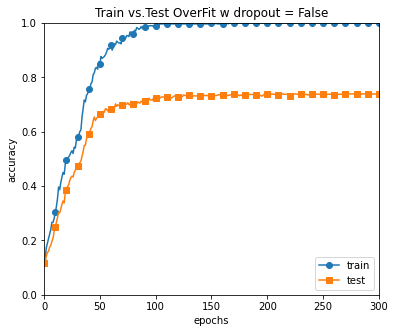

In [ ]:
# 6.4.3.3 Dropout 사용하지 않은 경우
# 그래프 생성=========
fig = plt.figure(figsize=(6,5))
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title ('Train vs.Test OverFit w dropout = False')
plt.xlim(0, 300)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

##### use_dropout = True

In [ ]:
# 6.4.3.4 Dropout 사용하지 않음 (# 6.4.3.2 미사용본과 비교)

# 은닉층 6개층 100개 노드
# 은닉층 활성화 함수 : ReLU
# 가중치 초기설정 : He

# 배치 사이즈 : 100
# 최대 반복 회수 : 301 epoch
# 훈련방식 : SGD   학습률 0.01


# 훈련데이터 크기 : 300

# 실험 드롭아웃 사용여부에 따른 비교 (dropout_ratio = 0.2)

import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해서 학습 데이터를 제거
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuout의 유무, 비율의 설정  ========================
use_dropout = True  # Dropout을 사용 ***
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(
            input_size=784,
            hidden_size_list=[100, 100, 100, 100, 100, 100],
            output_size=10,
            use_dropout=use_dropout,
            dropout_ration=dropout_ratio)


# Trainer 클래스는 간소화 된 훈련 로직 (훈련 로직을 담고 있는 클래스)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01},
                  verbose=True)
# 훈련 수행
trainer.train()

# 훈련 중 정확도 측정 정보
train_acc_list, test_acc_list =\
   trainer.train_acc_list, trainer.test_acc_list


train loss:2.301224856414432
=== epoch:1, train acc:0.12333333333333334, test acc:0.1062 ===
train loss:2.307357100415924
train loss:2.303165261612259
train loss:2.29458053042421
=== epoch:2, train acc:0.12333333333333334, test acc:0.1083 ===
train loss:2.2955899230268937
train loss:2.3102002774719326
train loss:2.2962144940366516
=== epoch:3, train acc:0.12333333333333334, test acc:0.1105 ===
train loss:2.2991050864795866
train loss:2.3042817517685363
train loss:2.2958615863472094
=== epoch:4, train acc:0.12666666666666668, test acc:0.1137 ===
train loss:2.2998699166952576
train loss:2.299047249147036
train loss:2.3016578151765317
=== epoch:5, train acc:0.12333333333333334, test acc:0.1142 ===
train loss:2.30338623286743
train loss:2.2939065436367136
train loss:2.2975598512591136
=== epoch:6, train acc:0.13, test acc:0.1146 ===
train loss:2.2938115617406294
train loss:2.3010843822838662
train loss:2.2925592537529487
=== epoch:7, train acc:0.12666666666666668, test acc:0.1167 ===
train

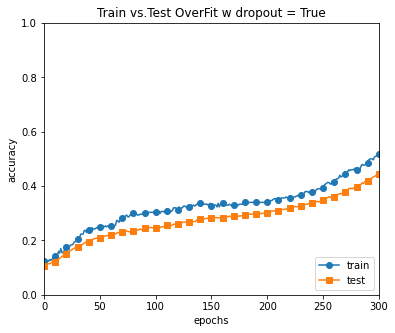

In [ ]:
# 6.4.3.5 Dropout 사용한 경우
# 그래프 생성=========
fig = plt.figure(figsize=(6,5))
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title ('Train vs.Test OverFit w dropout = True')
plt.xlim(0, 300)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.5 적절한 하이퍼파라미터 값 찾기


### 6.5.1 검증데이터

In [ ]:
# 6.5.1.1 훈련데이터에서 검증 데이터 분할 수행을 위해 섞는 (shuffle) 함수

def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]
    return x, t

In [ ]:
# 6.5.1.2 검증데이터 분할
# MNIST 적재
(x_train, t_train) , (x_test, t_test) = load_mnist()

# 훈련데이터를 셔플
x_train, t_train = shuffle_dataset (x_train, t_train)

# 검증데이터의 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 6.5.2 하이퍼파라미터의 최적화


* 0단계 : 하이퍼파리미터 값의 범위를 설정
* 1단계 : 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출
* 2단계 : 1단계에서 샘플링한 하이퍼파라미터의 값을 사용하여 학습하고, 검증데이터로 정확도를 평가. (에폭을 작게 설정)
* 3단계 : 1단계와 2단계를 특정 횟수 (100 회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁혀나간다.

### 6.5.3 하이퍼파라미터의 최적화 구현하기

* 하이퍼파라미터 중 가중치 감소 계수 weight_decay와 학습률 learning rate의 적절한 값을 찾아본다.


In [ ]:
# 6.5.3.1  가중치감소계수와 학습률 초기 값 무작위 설정 예
weight_decay = 10 ** np.random.uniform(-8, -4) # 0.00000001 ~0.0001
lr = 10 ** np.random.uniform (-6, -2) #  0.000001 ~ 0.01

weight_decay, lr

(2.798313472566174e-08, 0.00010225852113635806)

##### Various weight_decay, lr combination : Accuracy on train vs. validation

In [ ]:
# 6.5.3.2 가중치 감소계수와 학습률을 무작위로 100쌍을 조합하여 학습을 진행하고
#   검증 정확도가 좋은 20개 조합 (Top 20)의 wd와 lr을 관찰한다.

# 은닉층 6개층 100개 노드
# 은닉층 활성화 함수 : ReLU
# 가중치 초기설정 : He

# 배치 사이즈 : 100
# 최대 반복 회수 : 50 epoch
# 훈련방식 : SGD

# 훈련데이터 크기 : 500

# 실험 : 하이퍼파라미터 가중치감소계수와 학습률 탐색
# weight_decay = 10 ^-8 ~ 10^-4 ( 0.000_000_01 ~ 0.0001)
# lr = 10^-6 ~ 10^-2 (0.000_001 ~ 0.01 )


import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

# MNIST 데이터 적재
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 고속화를 위해서 훈련데이터를 제거
x_train = x_train[:500]
t_train = t_train[:500]

# 검증데이터 분리
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

# 훈련 함수 정의
def __train(lr, weight_decay, epocs=50):
    # 신경망 생성
    network = MultiLayerNet(input_size=784,
                            hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10,
                            weight_decay_lambda=weight_decay)  #### 탐색대상

    # 트레이너 생성
    trainer = Trainer(network,             # 신경망
                      x_train, t_train,    # 훈련 데이터
                      x_val, t_val,        # 검증 데이터
                      epochs=epocs,        # 기본 에폭 50
                      mini_batch_size=100, # 배치 크기 100
                      optimizer='sgd',
                      optimizer_param={'lr': lr},  ##### 탐색대상
                      verbose=False)
    # 훈련 수행
    trainer.train()

    # 훈련 결과 훈련정확도, 검증정확도 반환
    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터의 랜덤 탐색 ======================================
optimization_trial = 100

#  하이퍼파라미터 조합 별 학습성능, 검증/훈련데이터별 저장 변수 초기화
results_val = {}
results_train = {}

# 100번 동안 다양한 조합 탐색
for i in range(optimization_trial):

    # 탐색할 하이퍼파라미터를 지정된 범위에서 무작위로 설정 ===============

    # weight_decay = 10 ^-8 ~ 10^-4 ( 0.000_000_01 ~ 0.0001)
    weight_decay = 10 ** np.random.uniform(-8, -4)

    # lr = 10^-6 ~ 10^-2 (0.000_001 ~ 0.01 )
    lr = 10 ** np.random.uniform(-6, -2)

    # =================================================================

    # 훈련 수행
    val_acc_list, train_acc_list = __train(lr, weight_decay)

    # 훈련 수행결과 최종 검증정확도와 lr, weight decay  출력
    print(f"[{i:3}th trial] val acc:{val_acc_list[-1]:6} |",
          f" weight decay:{weight_decay:.10f}, lr: {lr:.10f}")

    # 이번 loop에서 수행한 lr값 및 weight_decay 값을 키로 하는
    # results_val, results_train 사전에 각각의 accuracy list 를 저장한다.
    key = f"weight decay:{weight_decay:.10f}, lr:{lr:.10f}"
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

[  0th trial] val acc:  0.07 |  weight decay:0.0000013642, lr: 0.0000046376
[  1th trial] val acc:  0.55 |  weight decay:0.0000192384, lr: 0.0040826933
[  2th trial] val acc:  0.09 |  weight decay:0.0000001474, lr: 0.0000060533
[  3th trial] val acc:  0.14 |  weight decay:0.0000014514, lr: 0.0000813291
[  4th trial] val acc:  0.37 |  weight decay:0.0000002718, lr: 0.0023570356
[  5th trial] val acc:  0.09 |  weight decay:0.0000033990, lr: 0.0000513198
[  6th trial] val acc:  0.16 |  weight decay:0.0000271802, lr: 0.0013213007
[  7th trial] val acc:  0.09 |  weight decay:0.0000000847, lr: 0.0000935750
[  8th trial] val acc:  0.15 |  weight decay:0.0000000135, lr: 0.0000373729
[  9th trial] val acc:  0.05 |  weight decay:0.0000601866, lr: 0.0000024037
[ 10th trial] val acc:  0.18 |  weight decay:0.0000000573, lr: 0.0006748809
[ 11th trial] val acc:  0.75 |  weight decay:0.0000012689, lr: 0.0080082831
[ 12th trial] val acc:  0.25 |  weight decay:0.0000859577, lr: 0.0017073896
[ 13th trial

=========== Hyper-Parameter Optimization Result ===========
Best- 1 (val acc: 0.77)| weight decay:0.0000274646, lr:0.0085782844
Best- 2 (val acc: 0.76)| weight decay:0.0000002179, lr:0.0082609590
Best- 3 (val acc: 0.75)| weight decay:0.0000012689, lr:0.0080082831
Best- 4 (val acc: 0.72)| weight decay:0.0000013212, lr:0.0050659800
Best- 5 (val acc: 0.72)| weight decay:0.0000001943, lr:0.0051609867
Best- 6 (val acc: 0.69)| weight decay:0.0000000212, lr:0.0063629972
Best- 7 (val acc: 0.66)| weight decay:0.0000011766, lr:0.0071488818
Best- 8 (val acc: 0.58)| weight decay:0.0000036704, lr:0.0051290722
Best- 9 (val acc: 0.56)| weight decay:0.0000008746, lr:0.0029970969
Best-10 (val acc: 0.55)| weight decay:0.0000192384, lr:0.0040826933
Best-11 (val acc: 0.55)| weight decay:0.0000359659, lr:0.0042240627
Best-12 (val acc: 0.54)| weight decay:0.0000065644, lr:0.0037225505
Best-13 (val acc: 0.53)| weight decay:0.0000001634, lr:0.0050733508
Best-14 (val acc: 0.53)| weight decay:0.0000002756, lr:0

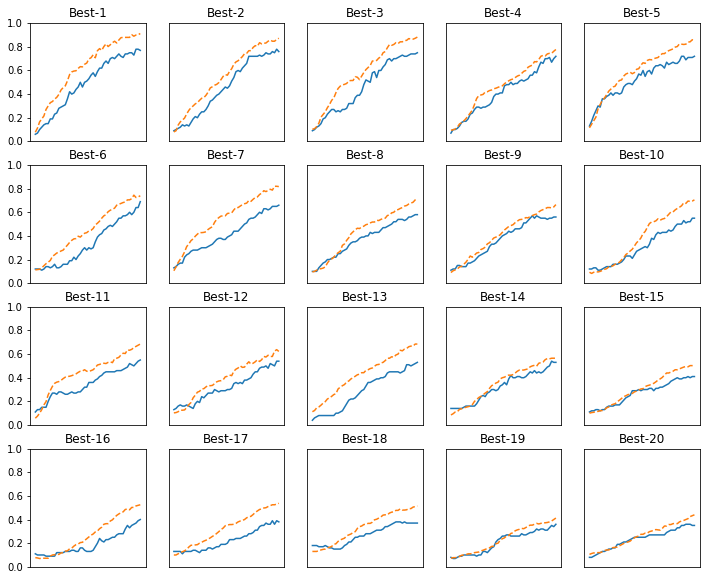

In [ ]:
# 6.5.3.3   #6.5.3.2 에서 시도한 100개의 조합 중에서 검증정확도 성능이 가장 좋은
#           20개를 발췌하여 학습과정을 그래프로 표현한다. (훈련 데이터/검증데이터)
#           weight_decay = 10 ^-8 ~ 10^-4 ( 0.000_000_01 ~ 0.0001)
#           lr = 10^-6 ~ 10^-2 (0.000_001 ~ 0.01 )
# 그래프 생성 ========================================================

# 그래프 초기화 / 결과 출력 제목
plt.figure(figsize = (12,10))
print("=========== Hyper-Parameter Optimization Result ===========")

# 그래프 그릴 갯수
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

# results_val의 값에 저장된 val_acc_list[-1] (=각 리스트 (각 조합의 시도)의 마지막값)의
# 내림차순으로 정렬하고 해당 시도의 하이퍼파라미터의 조합을 보여준다.
for key, val_acc_list in sorted(results_val.items(),
                                key=lambda x:x[1][-1], reverse=True):

    print(f"Best-{i+1:2} (val acc: {val_acc_list[-1]:.2f})| " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:    # 지정된 상위 개수 출력 후 종료
        break

plt.show()